In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import dask



## Reading in lofoten800 from thredds

thredds catalog : https://thredds.met.no/thredds/catalog/romshindcast/lofoten800_2016/catalog.html

In [11]:
# file names for the last half of the simulation period
base_url = "https://thredds.met.no/thredds/dodsC/romshindcast/lofoten800_2016/ocean_avg_"
urls = [base_url + f"{i:04d}.nc4" for i in np.arange(70,142)]

In [3]:
# drop some variables to decrease the file size. 
drop_variables = ["w", "aice", "hice", "shflux", "ssflux", "Pair", "temp", "salt", "u", "v"]

# read in the last year of data
ds = xr.open_mfdataset(urls[-12:], data_vars="minimal", parallel=True, drop_variables=drop_variables, chunks={"ocean_time":1})
ds

<xarray.Dataset>
Dimensions:         (tracer: 2, boundary: 4, s_rho: 35, s_w: 36, eta_rho: 1252,
                     xi_rho: 1302, eta_u: 1252, xi_u: 1301, eta_v: 1251,
                     xi_v: 1302, eta_psi: 1251, xi_psi: 1301, ocean_time: 360)
Coordinates:
  * s_rho           (s_rho) float64 -0.9857 -0.9571 ... -0.04286 -0.01429
  * s_w             (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(1252, 1302), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(1252, 1302), meta=np.ndarray>
    lon_u           (eta_u, xi_u) float64 dask.array<chunksize=(1252, 1301), meta=np.ndarray>
    lat_u           (eta_u, xi_u) float64 dask.array<chunksize=(1252, 1301), meta=np.ndarray>
    lon_v           (eta_v, xi_v) float64 dask.array<chunksize=(1251, 1302), meta=np.ndarray>
    lat_v           (eta_v, xi_v) float64 dask.array<chunksize=(1251, 1302), meta=np.ndarray>
    lon_psi         (eta_psi, xi_psi) float64 dask.array<chunksize=(1251, 1301), meta=np.ndarray>
    lat_psi         (eta_psi, xi_psi) float64 dask.array<chunksize=(1251, 1301), meta=np.ndarray>
  * ocean_time      (ocean_time) datetime64[ns] 2003-08-23 ... 2004-08-16
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/80)
    ntimes          int32 6235840
    ndtfast         int32 30
    dt              float64 60.0
    dtfast          float64 2.0
    dstart          datetime64[ns] 1993-01-16T12:00:00
    nHIS            int32 1440
    ...              ...
    ubar            (ocean_time, eta_u, xi_u) float32 dask.array<chunksize=(1, 1252, 1301), meta=np.ndarray>
    vbar            (ocean_time, eta_v, xi_v) float32 dask.array<chunksize=(1, 1251, 1302), meta=np.ndarray>
    sustr           (ocean_time, eta_u, xi_u) float32 dask.array<chunksize=(1, 1252, 1301), meta=np.ndarray>
    svstr           (ocean_time, eta_v, xi_v) float32 dask.array<chunksize=(1, 1251, 1302), meta=np.ndarray>
    bustr           (ocean_time, eta_u, xi_u) float32 dask.array<chunksize=(1, 1252, 1301), meta=np.ndarray>
    bvstr           (ocean_time, eta_v, xi_v) float32 dask.array<chunksize=(1, 1251, 1302), meta=np.ndarray>
Attributes: (12/32)
    file:                            /work/martatro/run/lofoten800_2016/ocean...
    format:                          netCDF-3 classic file
    Conventions:                     CF-1.4
    type:                            ROMS/TOMS nonlinear model averages file
    title:                           ROMS 3.5
    rst_file:                        /work/martatro/run/lofoten800_2016/ocean...
    ...                              ...
    compiler_flags:                  -mcmodel=large  -ip -O3 -free -free -free
    tiling:                          032x016
    history:                         ROMS/TOMS, Version 3.5, Friday - October...
    ana_file:                        ROMS/Functionals/ana_btflux.h, /home/met...
    CPP_options:                     NOSH2000M, ADD_FSOBC, ADD_M2OBC, ALBEDO,...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

In [4]:
ds.ubar

<xarray.DataArray 'ubar' (ocean_time: 360, eta_u: 1252, xi_u: 1301)>
dask.array<concatenate, shape=(360, 1252, 1301), dtype=float32, chunksize=(1, 1252, 1301), chunktype=numpy.ndarray>
Coordinates:
    lon_u       (eta_u, xi_u) float64 dask.array<chunksize=(1252, 1301), meta=np.ndarray>
    lat_u       (eta_u, xi_u) float64 dask.array<chunksize=(1252, 1301), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2003-08-23 2003-08-24 ... 2004-08-16
Dimensions without coordinates: eta_u, xi_u
Attributes:
    long_name:    time-averaged vertically integrated u-momentum component
    units:        meter second-1
    time:         ocean_time
    field:        ubar-velocity, scalar, series
    _ChunkSizes:  [   1 1252 1301]

## Smoothing
We will smooth the bottom topography.

What we do is a 2D convolution.

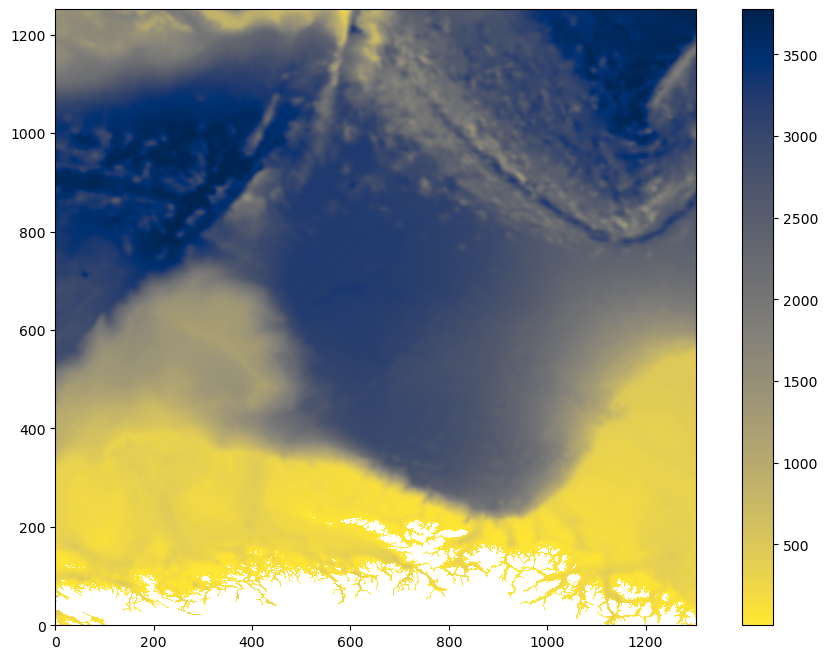

In [5]:
# extract the bottom topography from the dataset
depth = ds.where(ds.mask_rho).h

# plot the bottom topography 
fig, ax = plt.subplots(figsize=(12,8))
cb = ax.pcolormesh(depth, cmap="cividis_r")
fig.colorbar(cb)

ax.set_aspect("equal")

Text(0.5, 1.0, 'Original')

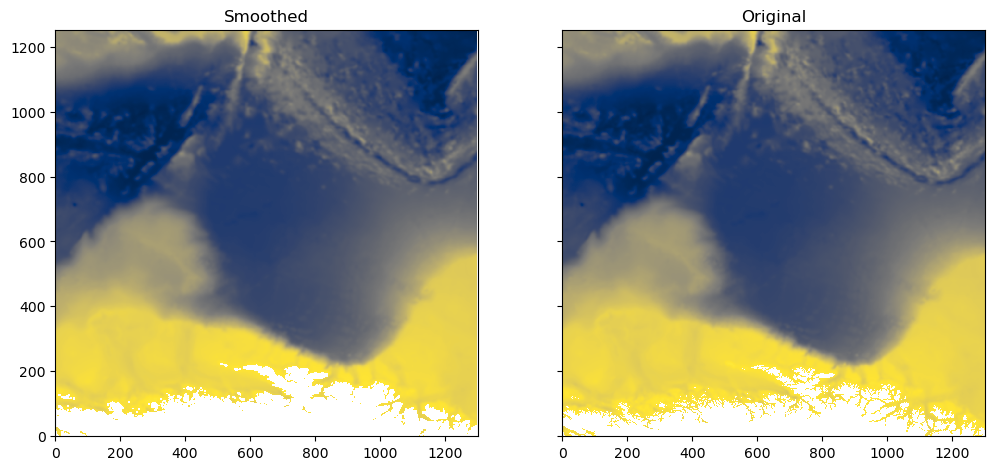

In [6]:
# a first attempt at smoothing. 
# this will take the mean over a quadratic box
rolling = depth.rolling({"xi_rho":5,"eta_rho":5}, center=True)
depth_filtered = rolling.mean()

# plot the smoothed bathymetry together with original bathymetry
fig, axes = plt.subplots(figsize=(12,8), ncols=2, sharex=True, sharey=True)
cb = axes[0].pcolormesh(depth_filtered, cmap="cividis_r")
axes[1].pcolormesh(depth, cmap="cividis_r")

axes[0].set_aspect("equal")
axes[1].set_aspect("equal")

axes[0].set_title("Smoothed")
axes[1].set_title("Original")

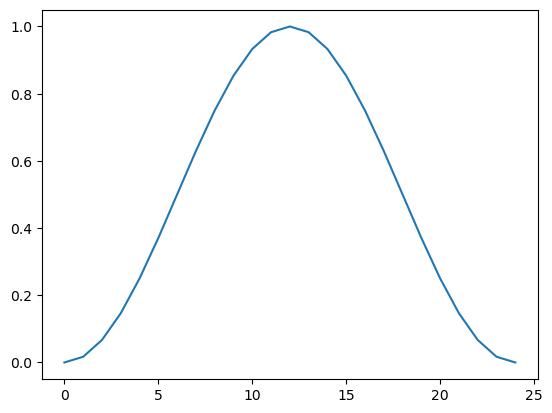

In [13]:
# We will now do a bit more advanced smoothing, where we use a different window than a quadratic box

# we first make a 1d hanning window. The window could be any shape. 
window = np.hanning(25)

fig, ax = plt.subplots()
ax.plot(window)

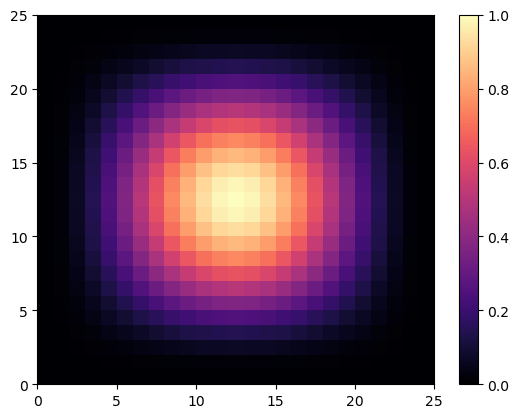

In [14]:
# we then make a 2d windom
X, Y =  np.meshgrid(window, window)
window2d = X*Y 

fig, ax = plt.subplots()
cb = ax.pcolormesh(window2d, cmap="magma")
fig.colorbar(cb)

In [15]:
# normalize the window so that it sums to 1
window2d = window2d/np.sum(window2d)

# lets check that it sums to 1
np.sum(window2d)

0.9999999999999999

In [16]:
window2d = xr.DataArray(window2d, dims=['x', "y"])

rolling = depth.rolling({"xi_rho":25,"eta_rho":25}, center=True)
depth_filtered = rolling.construct(xi_rho="x", eta_rho="y").dot(window2d)

Text(0.5, 1.0, 'Original')

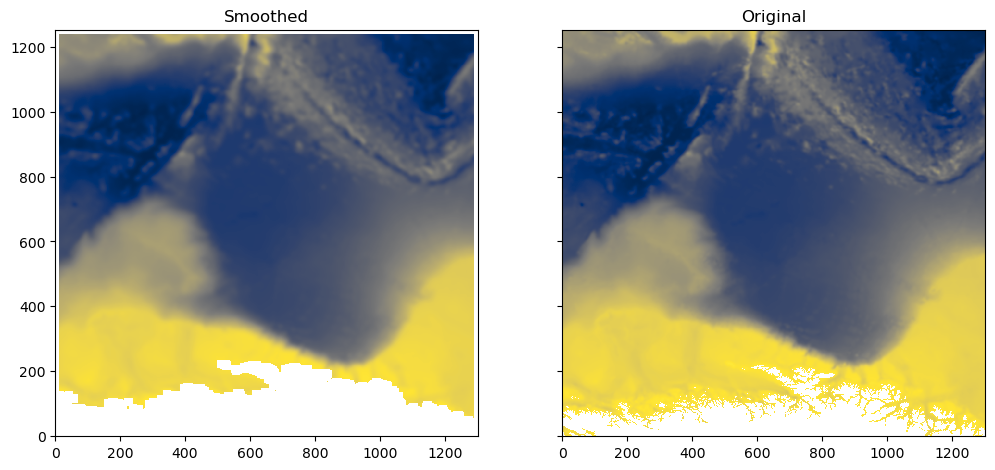

In [17]:
# plot the smoothed bathymetry together with original bathymetry
fig, axes = plt.subplots(figsize=(12,8), ncols=2, sharex=True, sharey=True)
cb = axes[0].pcolormesh(depth_filtered, cmap="cividis_r")
axes[1].pcolormesh(depth, cmap="cividis_r")

axes[0].set_aspect("equal")
axes[1].set_aspect("equal")

axes[0].set_title("Smoothed")
axes[1].set_title("Original")

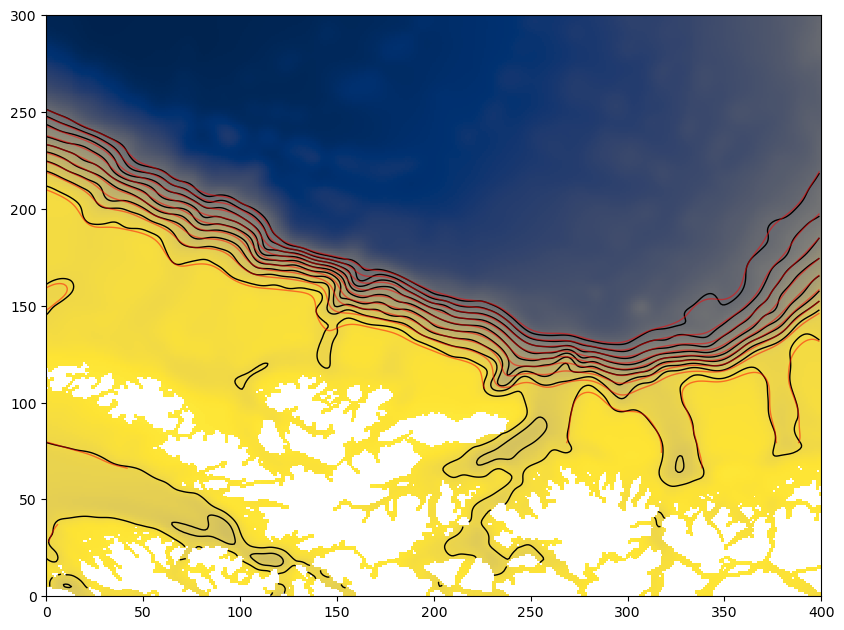

In [24]:
fig, ax = plt.subplots(figsize=(10,10))

levels = np.arange(200, 2000, 200)

ax.pcolormesh(depth[100 : 400, 600 : 1000], cmap="cividis_r")
ax.contour(depth[100 : 400, 600 : 1000], colors="black", levels=levels, linewidths=1)
ax.contour(depth_filtered[100 : 400, 600 : 1000], colors="red", levels=levels, linewidths=1, alpha=0.5)
ax.set_aspect("equal")